In [1]:
import pandas as pd
import talib
import numpy as np
from datetime import datetime

In [2]:
#Import the data file--> here the file is of 15min frequency, picked using zerodha pi
data = pd.read_csv('NIFTY 50.csv')
#Reindex the dataframe to sort the dates in ascending order
data = data.reindex(index=data.index[::-1])
data.reset_index(inplace = True)
data.drop("index", axis = 1, inplace = True)

#Using TAlib capture MACD(12,26) and ADX(14)
data["MACD"], data["MACD_signal"], macdhist = talib.MACD(data["Close"], fastperiod=12, slowperiod=26, signalperiod=9)
data["ADX"] = talib.ADX(data["High"], data["Low"], data["Close"], timeperiod=14)
data.dropna(inplace = True)
data.reset_index(inplace = True)
data.drop("index", axis =1, inplace = True)
#Slice the required columns to reduce future usage
data = data[["Date","Close","MACD","MACD_signal","ADX"]]
#Parse datetime to dates so that SL can be sent as exit positions at or before 3:30pm
data["Date"] = pd.to_datetime(data["Date"])

#### MACD crosses from below to MACD_signal --> Buy<br>
#### MACD crosses from above to MACD_signal --> Sell

In [3]:
#Setup the initial cash
initial_cash = 20000
#Setup the SL
sl = -1 * initial_cash/100
#Setup the columns required
data["Buy"] = 0
data["Sell"] = 0
data["order_status"] = 0
data["Stock_holding"] = 0
data["cash"] = initial_cash
data["trades"] = 0
data["SL"] = 0
data["PnL"] = 0
data["Trade_PnL"] = 0
data["total"] = 0
#The first element of Total column is initital cash only because in for loop we are not taking this first element
data["total"].loc[0] = initial_cash
#Initiate a for loop for whole dataframe except the first row
for i in range(1,data.shape[0]):
    #If MACD buy crossover takes place with ADX>30 and its before 3pm, then go long
    if data["MACD"][i]>data["MACD_signal"][i] and data["MACD"][i-1]<data["MACD_signal"][i-1] and data["ADX"][i]>30 and data["Date"][i].hour <15:
        #Set Buy to 1 and order status as 1 because we are taking the trade if there is no preexisting position open
        data["Buy"].loc[i] = 1
        data["order_status"].loc[i] = 1
    #IF MACD sell crossover takes place with ADX>30 and its before 3pm, then go short
    elif data["MACD"][i]<data["MACD_signal"][i] and data["MACD"][i-1]>data["MACD_signal"][i-1] and data["ADX"][i]>30 and data["Date"][i].hour <15:
        #Set Buy to 1 and order status as 1 because we are taking the trade if there is no preexisting position open
        data["Sell"].loc[i] = 1
        data["order_status"].loc[i] = -1
    else:
        #If there's neither sell or buy then set order status as the existing one and cash also as the existing because no changes
        data["order_status"].loc[i] = data["order_status"][i-1]
        data["cash"].loc[i] = data["cash"][i-1]
    #Create Stock holding value which tracks each data point, its not 0 if there's an open position
    data["Stock_holding"].loc[i] = data["order_status"][i] * data["Close"][i]
    #If there's a change in direction or SL is hit, set PnL to be 0, add 1 to the number of trades and adjust the cash to close the position and take new position if any
    if data["order_status"][i]!=data["order_status"][i-1]:
        data["Trade_PnL"].loc[i] = data["PnL"][i-1] + (data["Close"][i] - data["Close"][i-1]) * data["order_status"][i-1]
        data["trades"].loc[i] = data["trades"][i-1] + 1
        data["cash"].loc[i] = data["cash"][i-1] - data["Stock_holding"][i] + data["Stock_holding"][i-1] + (data["Close"][i] - data["Close"][i-1]) * data["order_status"][i-1] 
    else:
        #If there's no signal, then let trades be as it is as well as the cash
        data["trades"].loc[i] = data["trades"][i-1]
        data["cash"].loc[i] = data["cash"][i-1]
    #Sum up the cash and stock holding to know the account value
    data["total"].loc[i] = data["cash"][i] + data["Stock_holding"][i]
    #Setup the PnL which will help to trigger SL order
    if data["order_status"][i]==data["order_status"][i-1]:
        data["PnL"].loc[i] = data["total"][i] - data["total"][i-1] + data["PnL"][i-1]
        data["Trade_PnL"].loc[i] = data["PnL"].loc[i] 
    #If SL is hit and there's no opposite direction signal or time is 3:30pm then exit the current positions, set order status as 0, adjust the cash
    #Stock holdings to 0, reset the PnL and note that SL is hit, and update the total account value
    if (data["PnL"][i]<=sl and data["order_status"][i]==data["order_status"][i-1]) or (data["Date"][i].hour ==15 and data["Date"][i].minute==30):
        data["order_status"].loc[i] = 0
        data["cash"].loc[i] = data["cash"][i] + data["Stock_holding"][i] - data["PnL"][i] + sl 
        data["Stock_holding"].loc[i] = 0
        data["total"].loc[i] = data["cash"][i]
        data["PnL"].loc[i] = 0
        data["SL"].loc[i] = 1
        data["Trade_PnL"].loc[i] = sl
        
#Drop any nan value if present
data.dropna(inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


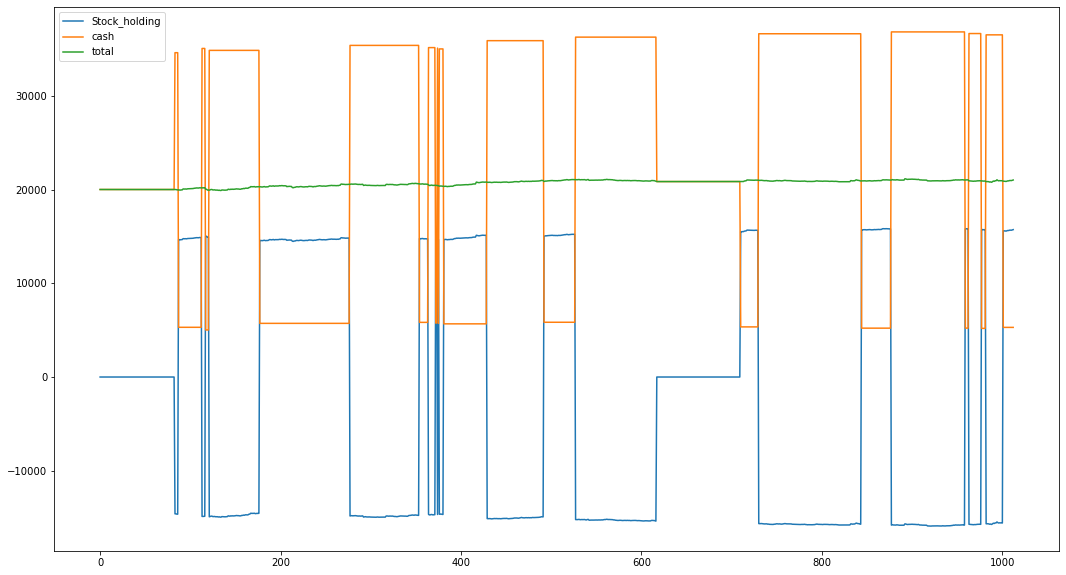

In [4]:
#Plot the curve containing holdings, cash and account value throughout the backtesting period
data[["Stock_holding","cash","total"]].plot(figsize = (18,10))

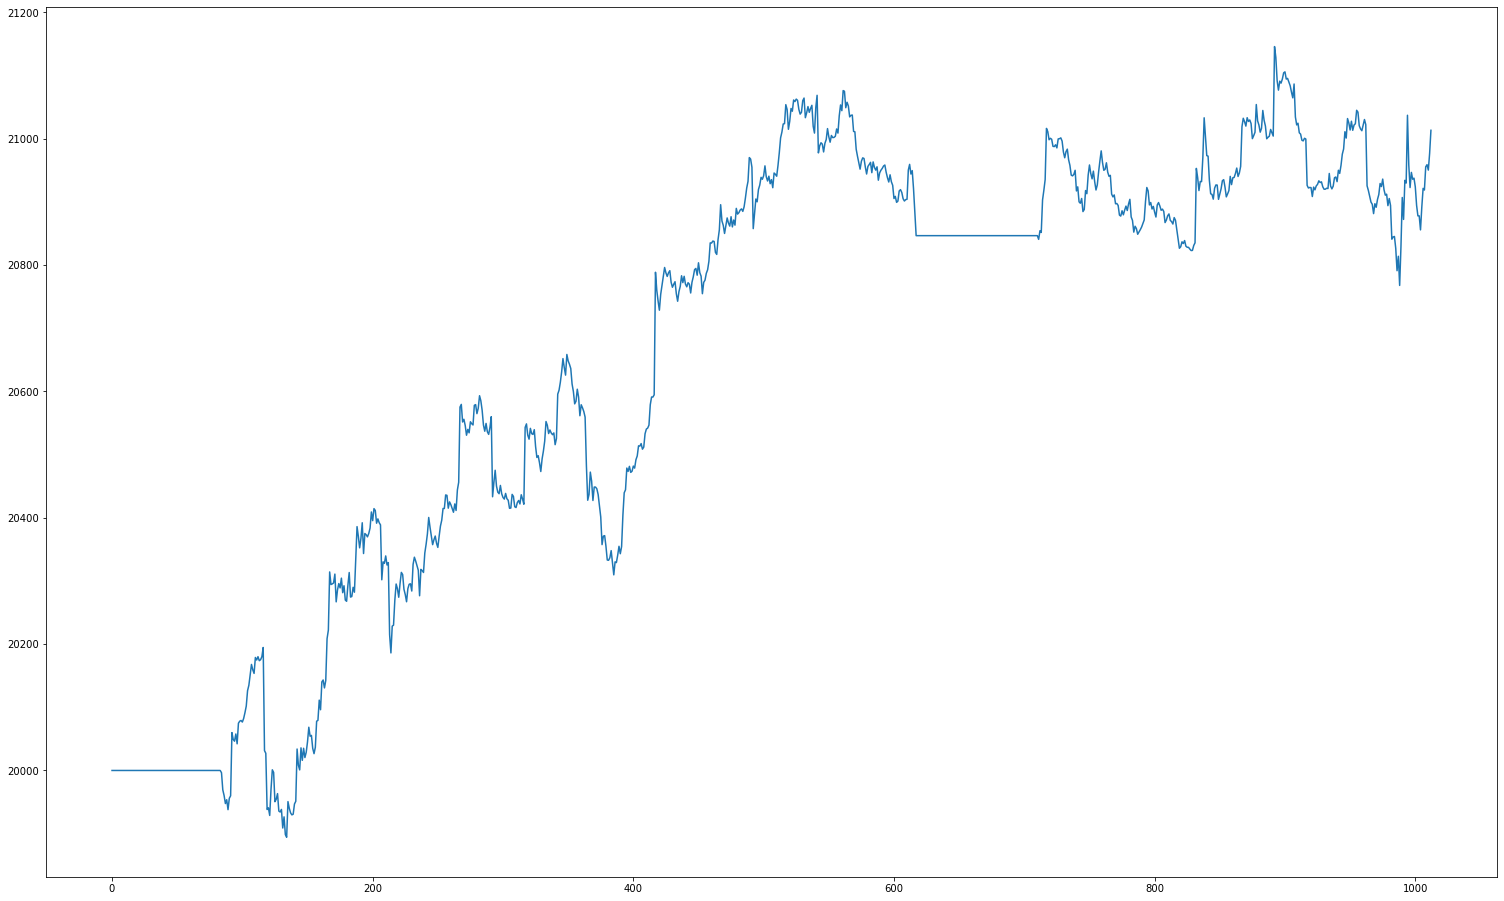

In [5]:
#Plot the account value throughout the backtesting period to get an idea of the strategy
data["total"].plot(figsize = (26,16))

In [6]:
#To DO,
# '''
# 1. Introduce KPIs to analyze the strategy --> Max Drawdown, % profitable,R2R, Sharpe Ratio, Sortino Ratio
# 2. Optimize SL on my analysis of Nifty daily and try to use day wise analysis too
# 3. Optimize Indicators signal periods for best PnL
# 4. Calculate consecutive trade losses
# 5. Incorporate slippage and brokerages
# 6. Optimize the code, currently it takes about 2 seconds for 1100 values
# 7. Plot the buy sell order on the graph
# 8. Verify with trading view for the value of MACD and ADX
# 9. Check whether options could be traded on this?
# 10. Create a GUI to backtest strategies which will let you not interfere with the code again and again
# 11. Try to look for patterns like candlesticks to optimize the strategy or something like be long only after 9:30pm
# 12. Try plotly to plot the graph to make it interactive so that everytime you don't have to look into the dataframe
# 13. Try to backtest strategies on past data to remove seasonality
# 14. Incorporate Bid Ask Spread
# 15. Try other indicators too
# 16. Try plotting MACD and ADX below the above graph too like how its done in TradingView
# 17. Try using Objected Oriented Programming if possible
# 18. Try using Threading or Multiprocessing to optimize time and get better results
# 19. 
# '''


In [9]:
#Generate the trade log
trade_log = data[data["trades"]!=0]
sl_triggered_trades = data[data["SL"]==1][["trades","Trade_PnL"]]
sl_triggered_trades["trades"] = sl_triggered_trades["trades"]-1

counter = 0
sl_counter = 0
trade_no = []
trade_pnl_log = []
for i in range(trade_log.shape[0]):
    if trade_log.iloc[i]["trades"]!=counter:
        if sl_counter!=0:
            sl_counter = 0
            counter = counter+1
        else:
            trade_no.append(counter)
            counter = counter+1
            trade_pnl_log.append(trade_log.iloc[i]["Trade_PnL"])
    elif trade_log.iloc[i]["SL"]==1:
        trade_no.append(counter)
        sl_counter = 1
        trade_pnl_log.append(trade_log.iloc[i]["Trade_PnL"])
        
all_trades_log = pd.DataFrame([trade_no,trade_pnl_log]).T
all_trades_log.columns = ["Trade No.","PnL"]
all_trades_log = all_trades_log.loc[1:]
all_trades_log.reset_index(inplace = True)
all_trades_log.drop("index", axis = 1,inplace = True)

In [31]:
#KPIs
#Starting and ending cash
starting_equity = initial_cash
ending_equity = data.iloc[-1]["total"]
#Period of Strategy
start_date = data[data["trades"]==1].iloc[0]["Date"]
end_date = data.iloc[-1]["Date"]
#Net Profit
net_profit = ending_equity - starting_equity
#Annualized CAGR, note 25 means 25 15min candle in a trading day, and trading period is the period when we are holding the money
ann_cagr = round(100*((1 + net_profit/starting_equity) ** (1/(data[data["order_status"]!=0].shape[0]/(25*252))) -1),2)
#Total Trades
total_trades = data.iloc[-1]["trades"]
#%win
win_pct = 100 * all_trades_log[all_trades_log["PnL"]>=0].shape[0]/all_trades_log.shape[0]
#%loss
loss_pct = 100- win_pct
#Risk to Reward
r2r = round(all_trades_log[all_trades_log["PnL"]>=0]["PnL"].mean()/abs(all_trades_log[all_trades_log["PnL"]<0]["PnL"].mean()),2)
#Average Profit
avg_profit = round(all_trades_log[all_trades_log["PnL"]>0]["PnL"].mean(),2)
#Average Loss
avg_loss = round(all_trades_log[all_trades_log["PnL"]<0]["PnL"].mean(),2)
#Largest win and lowest win %
largest_win  = round(all_trades_log[all_trades_log["PnL"]>0]["PnL"].max()*100/starting_equity,2)
largest_loss  = round(all_trades_log[all_trades_log["PnL"]<0]["PnL"].min()*100/starting_equity,2)
#Calculate max Consecutive losses and wins
consec_loss = 0
consec_win = 0
counter_loss = 0
counter_win = 0
for i in range(all_trades_log.shape[0]):
    if all_trades_log["PnL"][i]<0:
        counter_loss =  counter_loss + 1
    else:
        counter_loss = 0
    if all_trades_log["PnL"][i]>=0:
        counter_win = counter_win +1
    else:
        counter_win = 0
    consec_loss = max(consec_loss, counter_loss)
    consec_win = max(consec_win, counter_win)
sharpe_ratio = (ann_cagr/100 - 0.052)/(data["total"].pct_change().std(ddof = 1)* np.sqrt(252*25))

In [36]:
print(sharpe_ratio)
print(win_pct)

4.627144706571042
44.0


4.627144706571042